In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
bg = Population(N=1000, tau=1e-2, phi=phi, name='bg')
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8) 

S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=5) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,ctx.size, seed=29) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

J_cc = SparseConnectivity(source=ctx, target=ctx, p=0.05)
synapse_cc = LinearSynapse(J_cc.K, A=5)
J_cc.store_attractors(patterns_ctx[0], patterns_ctx[0], synapse_cc.h_EE, 
                      plasticity.f, plasticity.g)
J_bb = SparseConnectivity(source=bg, target=bg, p=0.05)
synapse_bb = LinearSynapse(J_bb.K, A=5)
J_bb.store_attractors(patterns_bg[0], patterns_bg[0], synapse_bb.h_EE, 
                      plasticity.f, plasticity.g)
J_cb  = SparseConnectivity(source=bg, target=ctx, p=0.05)
synapse_cb = LinearSynapse(J_cb.K, A=1)
J_cb.store_attractors(patterns_bg[0], patterns_ctx[0], synapse_cb.h_EE, 
                      plasticity.f, plasticity.g)

J_bc = SparseConnectivity(source=ctx, target=bg, p=0.05)
synapse_bc = LinearSynapse(J_bc.K, A=0)
J_bc.store_sequences(patterns_ctx, patterns_bg, synapse_bc.h_EE, plasticity.f, plasticity.g)
# J_bc.update_sequences(patterns_ctx[0][0], patterns_bg[0][1],
#                    .6, lamb=1,f=plasticity.f, g=plasticity.g)
# J_bc.update_sequences(patterns_ctx[0][1], patterns_bg[0][2],
#                    .6, lamb=1,f=plasticity.f, g=plasticity.g)
# J_bc.update_sequences(patterns_ctx[0][2], patterns_bg[0][0],
#                    .6, lamb=1,f=plasticity.f, g=plasticity.g)
# J_bc.update_sequences(patterns_ctx[0][0], patterns_bg[0][2],
#                    .4, lamb=1,f=plasticity.f, g=plasticity.g)
# J_bc.update_sequences(np.random.randn(ctx.size), np.random.randn(bg.size),
#                    0.7, lamb=1,f=plasticity.f, g=plasticity.g)
net_ctx = RateNetwork(ctx, c_EE=J_cc, c_IE=J_bc, formulation=4)
net_bg = RateNetwork(bg, c_II=J_bb, c_EI=J_cb, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████| 1000/1000 [00:00<00:00, 19257.42it/s]
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████| 1000/1000 [00:00<00:00, 20981.91it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing attractors
100%|██████████████████████████████████████| 1000/1000 [00:00<00:00, 21816.47it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 20.67it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [4]:
init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
init_input_bg = np.random.RandomState().normal(0,1,size=patterns_bg[0][0].shape)
# init_input_ctx = patterns_ctx[0][0]
# init_input_bg = patterns_bg[0][0]
T=30
mouse = ReachingTask(3, alpha=0.5)
# net_ctx.simulate_learning(mouse, net_bg, T, init_input_ctx, init_input_bg, 
#                           phi(patterns_ctx[0]), phi(patterns_bg[0]), plasticity, detection_thres=.23)
net_ctx.simulate_learning(mouse, net_bg, T, init_input_ctx, init_input_bg, 
                          patterns_ctx[0], patterns_bg[0], plasticity, detection_thres=.23)

INFO:network:Integrating network dynamics
  0%|▏                                        | 108/29999 [00:24<48:14, 10.33it/s]

null-->lick


  2%|▉                                       | 744/29999 [00:25<01:14, 394.58it/s]

lick-->aim


  5%|█▊                                     | 1429/29999 [00:26<00:54, 527.16it/s]

aim-->aim
aim-->reach
reach-->reach


  7%|██▋                                    | 2069/29999 [00:28<00:53, 526.10it/s]

reach-->lick
Mouse received reward


  8%|██▉                                    | 2279/29999 [00:28<00:53, 516.96it/s]

lick-->aim
aim-->aim


  9%|███▌                                   | 2756/29999 [00:29<00:52, 519.34it/s]

aim-->reach


 11%|████                                   | 3172/29999 [00:30<00:52, 510.87it/s]

reach-->lick
Mouse received reward


 13%|████▉                                  | 3805/29999 [00:31<00:49, 529.22it/s]

lick-->aim


 13%|█████▏                                 | 4016/29999 [00:31<00:50, 515.92it/s]

aim-->reach
reach-->reach


 14%|█████▌                                 | 4278/29999 [00:32<00:50, 510.61it/s]

reach-->lick
Mouse received reward


 15%|██████                                 | 4642/29999 [00:33<00:49, 513.49it/s]

lick-->aim


 17%|██████▌                                | 5009/29999 [00:33<00:48, 516.68it/s]

aim-->reach


 17%|██████▊                                | 5222/29999 [00:34<00:47, 518.87it/s]

reach-->lick
Mouse received reward


 19%|███████▎                               | 5593/29999 [00:34<00:46, 523.65it/s]

lick-->lick
lick-->aim


 20%|███████▋                               | 5913/29999 [00:35<00:45, 526.05it/s]

aim-->reach


 20%|███████▉                               | 6125/29999 [00:35<00:45, 521.20it/s]

reach-->lick
Mouse received reward


 23%|████████▊                              | 6752/29999 [00:37<00:45, 505.41it/s]

lick-->aim


 23%|████████▉                              | 6905/29999 [00:37<00:46, 501.97it/s]

aim-->reach


 24%|█████████▏                             | 7112/29999 [00:38<00:45, 501.16it/s]

reach-->lick
Mouse received reward


 25%|█████████▋                             | 7478/29999 [00:38<00:43, 519.05it/s]

lick-->aim


 26%|██████████                             | 7743/29999 [00:39<00:42, 524.97it/s]

aim-->reach


 26%|██████████▎                            | 7902/29999 [00:39<00:42, 517.36it/s]

reach-->reach
reach-->lick
Mouse received reward


 28%|███████████                            | 8541/29999 [00:40<00:40, 526.45it/s]

lick-->aim


 29%|███████████▍                           | 8806/29999 [00:41<00:40, 520.99it/s]

aim-->reach


 30%|███████████▋                           | 8966/29999 [00:41<00:40, 524.79it/s]

reach-->lick
Mouse received reward


 32%|████████████▍                          | 9608/29999 [00:42<00:39, 522.00it/s]

lick-->aim


 33%|████████████▉                          | 9982/29999 [00:43<00:38, 526.13it/s]

aim-->reach


 34%|████████████▉                         | 10194/29999 [00:43<00:38, 519.49it/s]

reach-->lick
Mouse received reward


 35%|█████████████▍                        | 10565/29999 [00:44<00:36, 525.64it/s]

lick-->aim


 36%|█████████████▊                        | 10884/29999 [00:45<00:36, 527.22it/s]

aim-->reach
reach-->reach


 37%|█████████████▉                        | 11043/29999 [00:45<00:36, 523.24it/s]

reach-->lick
Mouse received reward


 38%|██████████████▍                       | 11363/29999 [00:46<00:35, 525.94it/s]

lick-->aim


 39%|██████████████▊                       | 11681/29999 [00:46<00:35, 520.74it/s]

aim-->reach


 40%|███████████████                       | 11893/29999 [00:47<00:34, 520.23it/s]

reach-->lick
Mouse received reward


 42%|███████████████▊                      | 12479/29999 [00:48<00:33, 526.03it/s]

lick-->aim


 42%|████████████████                      | 12691/29999 [00:48<00:33, 520.42it/s]

aim-->aim
aim-->reach


 43%|████████████████▎                     | 12903/29999 [00:49<00:33, 517.11it/s]

reach-->lick
Mouse received reward


 45%|█████████████████▏                    | 13534/29999 [00:50<00:32, 513.73it/s]

lick-->lick


 46%|█████████████████▎                    | 13691/29999 [00:50<00:31, 516.01it/s]

lick-->aim


 46%|█████████████████▌                    | 13900/29999 [00:51<00:31, 518.71it/s]

aim-->aim
aim-->aim
aim-->reach
reach-->reach
reach-->reach


 47%|█████████████████▊                    | 14057/29999 [00:51<00:30, 518.77it/s]

reach-->reach
reach-->lick
Mouse received reward


 48%|██████████████████▏                   | 14375/29999 [00:51<00:29, 525.38it/s]

lick-->aim


 49%|██████████████████▍                   | 14586/29999 [00:52<00:29, 521.99it/s]

aim-->reach


 49%|██████████████████▋                   | 14799/29999 [00:52<00:29, 517.71it/s]

reach-->lick
Mouse received reward


 50%|███████████████████▏                  | 15117/29999 [00:53<00:28, 521.79it/s]

lick-->aim


 51%|███████████████████▍                  | 15383/29999 [00:53<00:28, 520.09it/s]

aim-->reach
reach-->reach


 52%|███████████████████▊                  | 15595/29999 [00:54<00:27, 517.52it/s]

reach-->lick
Mouse received reward


 53%|████████████████████                  | 15858/29999 [00:54<00:27, 519.60it/s]

lick-->aim


 54%|████████████████████▍                 | 16121/29999 [00:55<00:27, 501.02it/s]

aim-->reach
reach-->reach
reach-->reach
reach-->reach


 55%|████████████████████▊                 | 16382/29999 [00:55<00:26, 507.70it/s]

reach-->lick
Mouse received reward


 57%|█████████████████████▍                | 16965/29999 [00:56<00:24, 529.79it/s]

lick-->aim


 58%|█████████████████████▉                | 17282/29999 [00:57<00:24, 518.23it/s]

aim-->reach
reach-->reach
reach-->reach
reach-->reach


 58%|██████████████████████▏               | 17491/29999 [00:57<00:24, 516.20it/s]

reach-->lick
Mouse received reward


 60%|██████████████████████▉               | 18126/29999 [00:59<00:22, 526.38it/s]

lick-->aim


 61%|███████████████████████▏              | 18339/29999 [00:59<00:22, 525.67it/s]

aim-->aim
aim-->reach
reach-->reach


 62%|███████████████████████▍              | 18551/29999 [00:59<00:21, 521.44it/s]

reach-->lick
Mouse received reward


 64%|████████████████████████▏             | 19138/29999 [01:01<00:20, 529.21it/s]

lick-->aim


 64%|████████████████████████▌             | 19349/29999 [01:01<00:20, 519.58it/s]

aim-->reach


 65%|████████████████████████▋             | 19508/29999 [01:01<00:20, 523.04it/s]

reach-->lick
Mouse received reward


 66%|█████████████████████████             | 19826/29999 [01:02<00:19, 513.93it/s]

lick-->aim


 67%|█████████████████████████▍            | 20089/29999 [01:02<00:19, 518.17it/s]

aim-->aim
aim-->aim
aim-->reach


 68%|█████████████████████████▋            | 20298/29999 [01:03<00:18, 518.74it/s]

reach-->lick
Mouse received reward


 70%|██████████████████████████▌           | 20941/29999 [01:04<00:17, 525.59it/s]

lick-->reach


 70%|██████████████████████████▋           | 21100/29999 [01:04<00:17, 523.30it/s]

reach-->lick


 72%|███████████████████████████▍          | 21683/29999 [01:06<00:15, 523.21it/s]

lick-->aim


 73%|███████████████████████████▋          | 21896/29999 [01:06<00:15, 526.41it/s]

aim-->reach
reach-->reach
reach-->reach


 74%|████████████████████████████          | 22162/29999 [01:06<00:15, 522.12it/s]

reach-->lick
Mouse received reward


 75%|████████████████████████████▌         | 22588/29999 [01:07<00:14, 515.19it/s]

lick-->aim


 76%|█████████████████████████████         | 22908/29999 [01:08<00:13, 528.95it/s]

aim-->aim
aim-->reach


 77%|█████████████████████████████▏        | 23068/29999 [01:08<00:13, 525.31it/s]

reach-->lick
Mouse received reward


 79%|██████████████████████████████        | 23708/29999 [01:09<00:11, 530.70it/s]

lick-->aim


 80%|██████████████████████████████▎       | 23974/29999 [01:10<00:11, 522.58it/s]

aim-->reach


 81%|██████████████████████████████▋       | 24186/29999 [01:10<00:11, 518.94it/s]

reach-->lick
Mouse received reward


 83%|███████████████████████████████▍      | 24770/29999 [01:11<00:10, 522.71it/s]

lick-->aim


 83%|███████████████████████████████▋      | 25035/29999 [01:12<00:09, 518.90it/s]

aim-->aim
aim-->reach


 84%|████████████████████████████████      | 25300/29999 [01:12<00:09, 519.77it/s]

reach-->lick
Mouse received reward


 85%|████████████████████████████████▏     | 25456/29999 [01:13<00:08, 517.43it/s]

lick-->aim


 86%|████████████████████████████████▌     | 25721/29999 [01:13<00:08, 522.55it/s]

aim-->reach
reach-->reach


 86%|████████████████████████████████▊     | 25932/29999 [01:14<00:07, 517.67it/s]

reach-->lick
Mouse received reward


 87%|█████████████████████████████████▏    | 26195/29999 [01:14<00:07, 520.96it/s]

lick-->aim


 88%|█████████████████████████████████▍    | 26408/29999 [01:15<00:06, 527.01it/s]

aim-->reach


 89%|█████████████████████████████████▋    | 26620/29999 [01:15<00:06, 520.00it/s]

reach-->lick
Mouse received reward


 89%|█████████████████████████████████▉    | 26829/29999 [01:15<00:06, 508.91it/s]

lick-->lick
lick-->aim


 90%|██████████████████████████████████▍   | 27143/29999 [01:16<00:05, 518.83it/s]

aim-->aim
aim-->reach


 91%|██████████████████████████████████▋   | 27352/29999 [01:16<00:05, 516.93it/s]

reach-->lick
Mouse received reward


 92%|███████████████████████████████████   | 27718/29999 [01:17<00:04, 516.54it/s]

lick-->aim


 93%|███████████████████████████████████▍  | 27984/29999 [01:18<00:03, 522.81it/s]

aim-->reach


 94%|███████████████████████████████████▋  | 28195/29999 [01:18<00:03, 521.55it/s]

reach-->lick
lick-->lick
Mouse received reward


 95%|████████████████████████████████████  | 28458/29999 [01:19<00:02, 520.22it/s]

lick-->lick
lick-->aim


 96%|████████████████████████████████████▍ | 28722/29999 [01:19<00:02, 518.64it/s]

aim-->reach


 96%|████████████████████████████████████▋ | 28930/29999 [01:19<00:02, 514.91it/s]

reach-->lick
Mouse received reward


 98%|█████████████████████████████████████▍| 29519/29999 [01:21<00:00, 530.79it/s]

lick-->reach


 99%|█████████████████████████████████████▋| 29732/29999 [01:21<00:00, 521.52it/s]

reach-->lick


100%|██████████████████████████████████████| 29999/29999 [01:22<00:00, 363.49it/s]


In [5]:
overlaps_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
# correlations_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi, correlation=True)
overlaps_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi)
# correlations_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi, correlation=True)

INFO:sequences:Computing overlaps
100%|███████████████████████████████████████████████| 3/3 [00:00<00:00, 16.45it/s]
INFO:sequences:Computing overlaps
100%|███████████████████████████████████████████████| 3/3 [00:00<00:00, 77.04it/s]


In [6]:
sns.set_style('dark') 
plt.rcParams["font.family"] = "arial"
colors = sns.color_palette('deep')

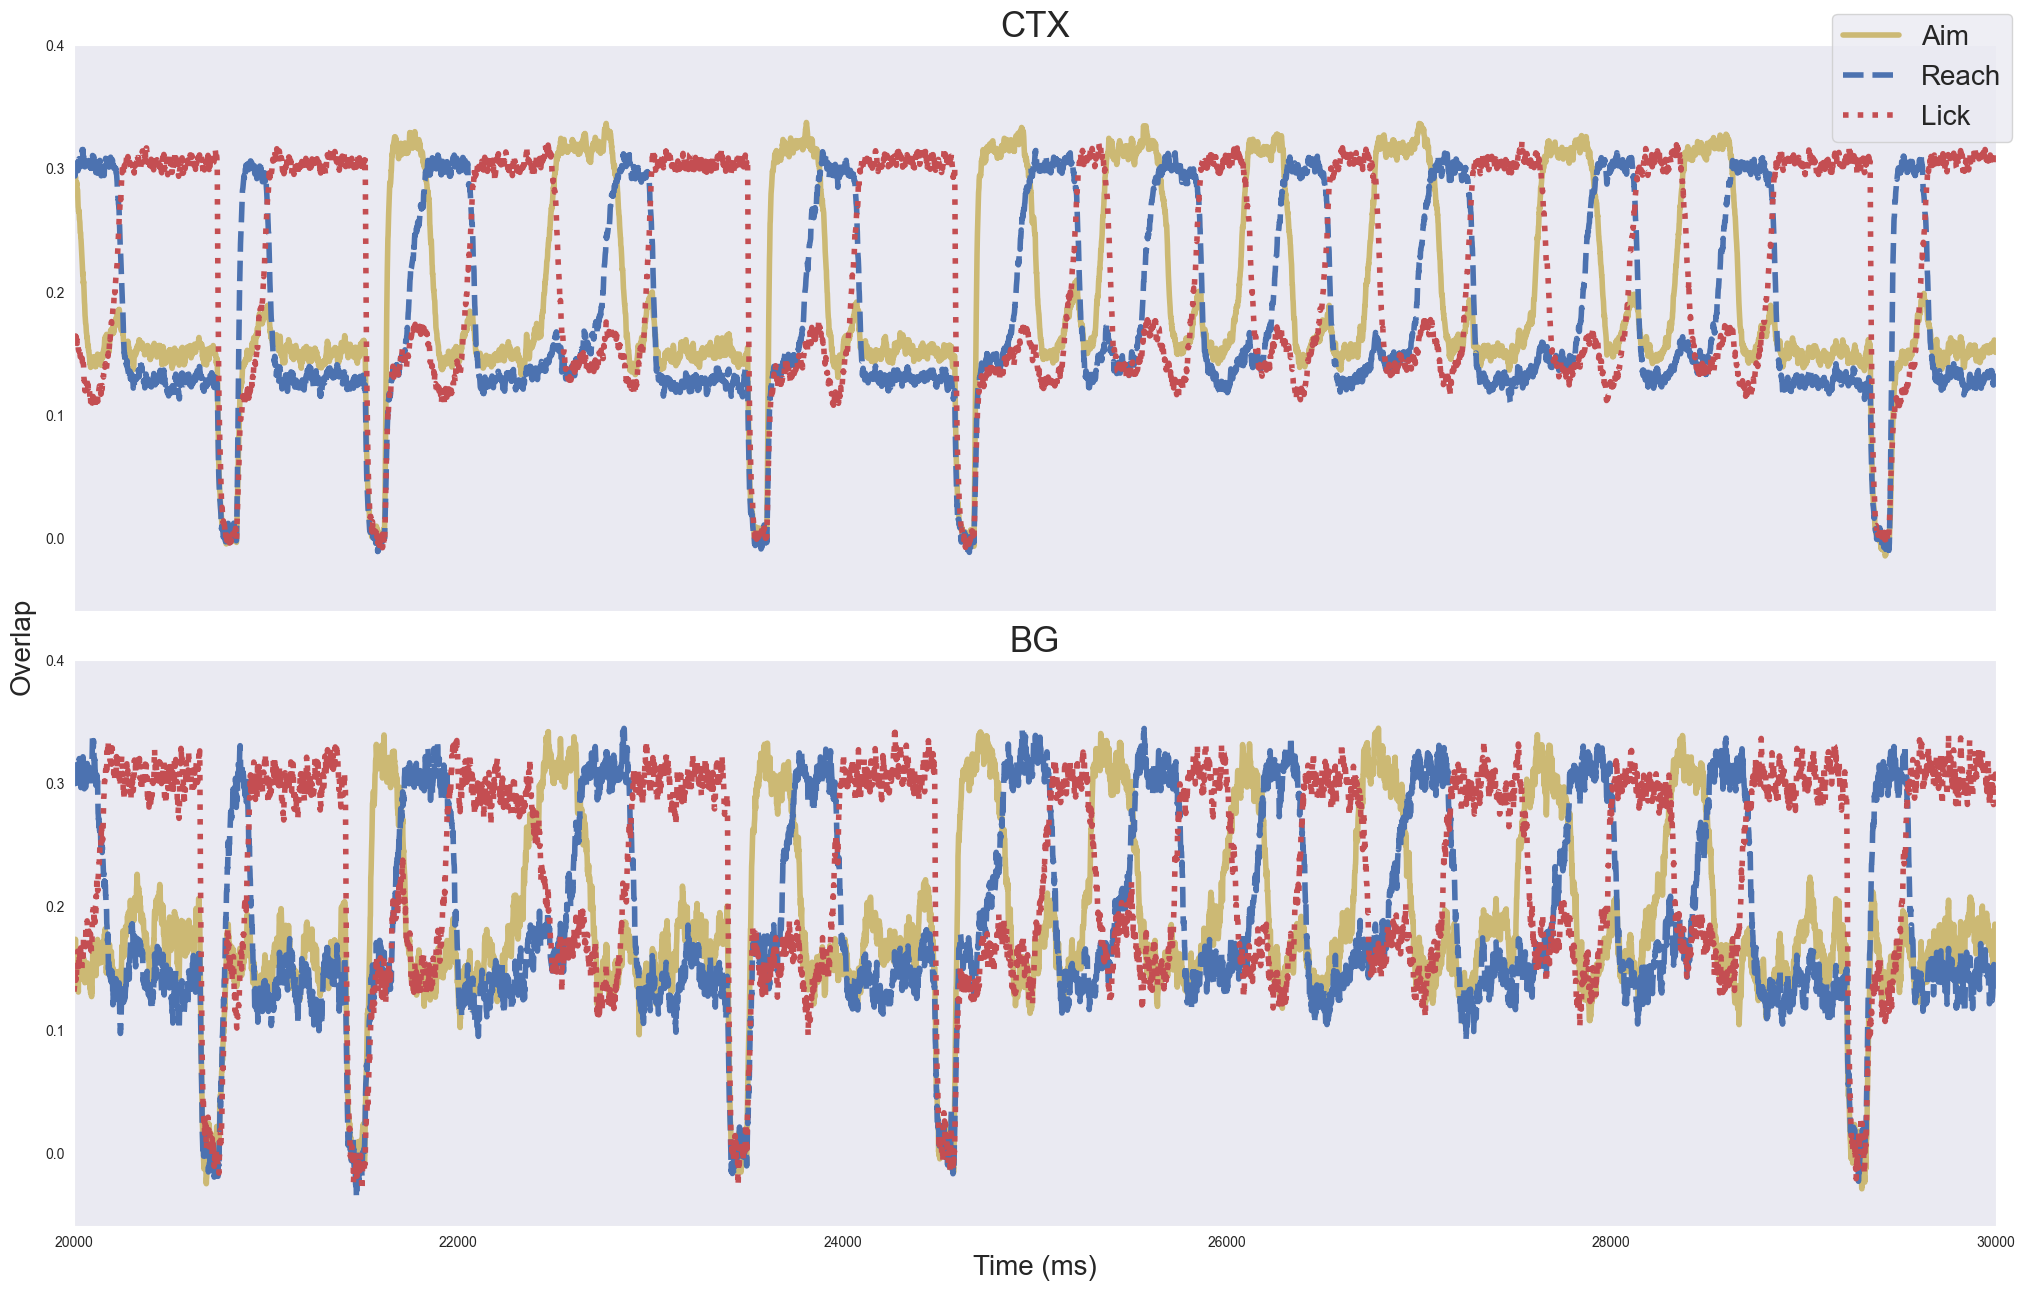

In [10]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=4, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_bg[0], linestyle='solid', linewidth=4, color=colors[8])
axes[1].plot(overlaps_bg[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[1].plot(overlaps_bg[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("BG", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(20000, 30000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.show()


In [8]:
mouse.calibrate()

ValueError: operands could not be broadcast together with shapes (144,) (172,) 

In [ ]:
np.savez('./output/test.npz', overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg)